In [ ]:
#Insert description for CDC paper here

In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import *
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import seaborn

In [2]:
#to reproduce paper results
np.random.seed(4)
torch.manual_seed(25) #not clear if this works in jupyter

In [3]:
#Function definitions

In [97]:
#basic functions

def prob_t_is_max(max_so_far, t, T):
    #conditionally independent probability that next iid sample of noise will be max over T
    coeff = 1.0/(T - t)
    prod = (1.0 - np.power(norm.cdf(max_so_far), T-t))
    return(coeff*prod)

def prob_any_next_t_is_max(max_so_far, t, T):
    #probability that any next T-t samples will be maximum over sequence of length T
    prod = (1.0 - np.power(norm.cdf(max_so_far), T-t))
    return(prod)

def log_utility(x):
    #example utility function, continuously differentiable, monotonically increasing first derivative
    #this example exhibits a diminishing return on increased power consumption x 
    y = 2.0*np.log(1 + np.power(x,1/2))
    return(np.sum(y))

def log_utility_opt_x(T, pi_cp):
    frac = (2*T)/pi_cp
    x_1 = frac + np.sqrt((frac - 1)*(frac + 1))
    x_2 = frac - np.sqrt((frac - 1)*(frac + 1))
    return((x_1, x_2))

def log_utility_opt_x_single_t(pi_cp):
    frac = (2)/pi_cp
    x_1 = frac + np.sqrt((frac - 1)*(frac + 1))
    x_2 = frac - np.sqrt((frac - 1)*(frac + 1))
    return((x_1, x_2))

def batch_data_arrays(data, labels, batchsize, sampledim = 1):
    #creates mini-batches and converts to Torch tensors for training
    remainder = data.shape[sampledim] % batchsize
    diff = batchsize - remainder
    tail = data[0,-diff:]
    out = [ (torch.Tensor(data[:,i*batchsize:(i+1)*batchsize].T), torch.Tensor(labels[i*batchsize:(i+1)*batchsize])) for i in range(int(float(data.shape[sampledim])/float(batchsize))) ]
    return(out)

In [5]:
#Neural network class definition and training helper function
#This neural network learns an approximate deterministic policy

class nnet(nn.Module):
    #a linear neural network with a sigmoid activiation function and a single hidden layer
    def __init__(self, params):
        super(nnet, self).__init__()
        self.D_in = params['FEATURE_DIM']
        self.H1 = params['HIDDEN_1']
        self.D_out = params['OUTPUT_DIM']
        self.l1 = nn.Linear(self.D_in, self.H1)
        self.l2 = nn.Linear(self.H1, self.D_out)
    
    def forward(self, x):
        x = torch.sigmoid(self.l1(x)) #sigmoid activation
        x = self.l2(x) #hidden layer
        return(x)
    
    
def train(net_obj, loss_func, opt_func, trainX, trainY, valX, valY, batchsize=100, epochs=50, verbose=True):
    print("Training")
    train_batches = batch_data_arrays(trainX, trainY, batchsize)
    num_batches = len(train_batches)
    
    train_epoch_loss = []
    val_epoch_loss = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        #iterate over minibatches
        for i, data in enumerate(train_batches):
            inputs, labels = data[0], data[1].unsqueeze(1)
            
            #make Variable
            inputs, labels = Variable(inputs), Variable(labels) 
            #inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            
            #zero gradient
            opt_func.zero_grad()
            
            #compute training loss
            outputs = net_obj(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            opt_func.step()
            
            running_loss += 0.0
        
        #compute validation loss
        train_epoch_loss.append(running_loss)
        val_out = net_obj(torch.Tensor(valX.T))
        val_loss = loss_func(val_out, torch.Tensor(valY).unsqueeze(1))
        val_epoch_loss.append(val_loss)
        
        #output progress
        if verbose==True:
            print("==epoch " + str(epoch) + "==")
            print("training loss: " + str(running_loss))
            print("validation loss: " + str(val_loss))
        
    #neural network object updated inplace, return loss over epochs
    return(train_epoch_loss, val_epoch_loss)

In [16]:
#global variables
x_bar = 1.0   #maximum consumption
noise_var = 1.0    #variance of noise values
g = np.arange(0,1.1,0.1)  #discretization of space of power consumption values x \in [0,\bar{x}]
s_vals = np.arange(-2.0,2.0,0.1)  #discretization of space of noise values, 98% of normal distribution with unit variance
samples = np.random.normal(0, noise_var, size=100000)
s_hist = np.histogram(samples, bins=np.arange(-2.0,2.1,0.1), normed=True)[0]
s_hist = (1.0/np.linalg.norm(s_hist, ord=1)) * s_hist #probabilities over discretized noise values
ramp_const = 0.3  #time coupling ramping constraint
pi_cp_perc = 0.6  #ratio of pi_cp cost to total utility under a naive fixed strategy

net_params = {'FEATURE_DIM': 4, 'OUTPUT_DIM': 1, 'HIDDEN_1': 16}

base_path = "/home/chase/projects/peakload/notebooks/" #change this to path to notebook + data

In [7]:
#Monte Carlo path sampling

In [8]:
def simulate_step(x_prev):
    g_const = g[(g >= x_prev - ramp_const) & (g <= x_prev + ramp_const)]
    x_next = np.random.choice(g_const)
    s_next = np.random.choice(s_vals, p=s_hist)
    return(x_next, s_next)

def generate_sample_paths(T, N=1000, sim_MC=100):
    #T is the total depth of simulations
    #N is the total number of sample paths to simulate
    #sim_MC is the number of Monte Carlo iterations per simulation
    
    samples_per_t = int(float(N)/float(T-1)) #divide sample paths amongst 
                                           #equal number of initial times t = [1,..., T]
        
    X = np.zeros((4,N))
    Y = np.zeros((N,))
    
    ind = np.arange(0, N, 1) #index for data matrix
    
    #pi_cp rate for T
    pi_cp = pi_cp_perc*T*log_utility(x_bar)
    
    for t in range(T-1):
        #for each initial t
        rounds_left = T-(t+1)
        for i in list(ind[t*samples_per_t:(t+1)*samples_per_t]):
            #populate features for sample path
            #sample initial value
            x_1 = np.random.choice(g)
            X[0,i] = x_1 #previous state
            
            s_m = 0.0
            for m in range(t):
                s_m = np.max([ s_m, np.random.choice(s_vals, p=s_hist) ])
            X[1,i] = s_m #maximum noise seen so far, previous values don't matter since less than this
            
            X[2,i] = float(rounds_left)/float(T) #normalized number of rounds left to go
            
            X[3,i] = np.random.uniform(0,1) #initialize linear bias weight
            
            #forward simulate for all possible next choices
            sim_rewards = {}
            
            for x_2_i in range(g.shape[0]):
                x_2 = g[x_2_i]
                if np.abs(x_2 - x_1) > ramp_const:
                    pass
                else:
                    #go forward for T-t
                    sim_rewards[x_2] = []
                    for s in range(sim_MC):
                        #initialize simulated path
                        s_2 = np.random.choice(s_vals, p=s_hist)
                        plays = [x_1, x_2]
                        noises = [s_m, s_2]
                        x_iter = x_2
                        for r in range(rounds_left):
                            x_iter, s_iter = simulate_step(x_iter)
                            plays.append(x_iter)
                            noises.append(s_iter)
                            
                        sim_reward = log_utility(plays) - pi_cp*plays[np.argmax(noises)]
                        sim_rewards[x_2].append(sim_reward)
            
            best_x_2 = 0
            best_expected_reward = 0.0
            for x_2 in sim_rewards:
                if np.mean(sim_rewards[x_2]) > best_expected_reward:
                    best_x_2 = x_2
                    best_expected_reward = np.mean(sim_rewards[x_2])
                    
            Y[i] = best_x_2
            
    return(X,Y)

In [156]:
#evaluation routine

def naive_optimal_utility(T):
    pi_cp = pi_cp_perc*T*log_utility(x_bar)
    naive_opt = np.min([x_bar, np.max(log_utility_opt_x(T, pi_cp))])  #utility fuction above has two optimal values, take larger constrained by maximum
    nopt_reward = T*log_utility(naive_opt) - pi_cp*naive_opt
    return(nopt_reward)

def grid_search_optimal(x_1_i, noise_sequence, grid):
    #returns the optimal plays iterating on a sequence of observed noise values
    #grid_search = np.load(grid_search_file_path)
    T = len(noise_sequence)
    x_curr = x_1_i
    outcomes = grid
    plays = [g[x_1_i]]
    for t in range(T-1):
        s_curr = noise_sequence[t]
        best_reward = 0
        best_x_2_i = 0
        outcomes = outcomes[x_curr, s_curr]
        g_const_i = np.arange(0,11,1)[(g <= g[x_curr] + ramp_const) & (g >= g[x_curr] - ramp_const)]
        for x_i in g_const_i:
            forward = outcomes[g_const_i]
            expected_reward = np.mean(forward[forward > 0])
            if expected_reward > best_reward:
                best_reward = expected_reward
                best_x_2_i = x_i
        plays.append(g[x_i])
        x_curr = x_i
    return(plays)
    
def evaluate_net(net_obj, T, pi_cp, naive_opt_reward, x_1=0.7, trials=100):
    winloss = []
    rewards = []
    for i in range(trials):
        noises = []
        plays = []
        x_curr = x_1
        for j in range(T): #includes initial round noise sample
            t = j+1
            s_t = np.random.choice(s_vals, p=s_hist)
            noises.append(s_t)
            
            s_m = np.max(noises) #max so far
            
            inputvec = torch.Tensor(np.array([x_curr, s_m, float(T-t)/float(T), 1.0])).unsqueeze(1).transpose(1,0)
            
            play_output = net_obj(inputvec)
            play = float(play_output.data[0,0])
            
            #snap to nearest value in range
            if play > x_bar: play = x_bar
            if play < 0.0: play = 0.0
                
            #snap to nearest feasible value if constraints violated
            if np.abs(x_curr - play) > ramp_const:
                if play > x_curr: play = x_curr + ramp_const
                if play < x_curr: play = x_curr - ramp_const
                    
            #attach previous play
            plays.append(x_curr)
            x_curr = play
            
        reward = log_utility(np.array(plays)) - pi_cp*plays[np.argmax(noises)]
        rewards.append(reward)
        
        if reward > naive_opt_reward: winloss.append(1)
        else: winloss.append(0)
            
    return(np.mean(winloss), np.mean(rewards))
    

In [11]:
#train networks
for T in range(2,11):
    print("Simulating: T=" + str(T) + "...")
    if T==8:
        X, Y = generate_sample_paths(T, N=T*500, sim_MC=100) #T=8 does significantly better with less samples, haven't optimized hyperparameters
    else:
        X, Y = generate_sample_paths(T, N=T*1000, sim_MC=100) #increase number of samples per increase in T
    
    #train/val split
    train_X = X[:,0:int(0.8*X.shape[1])]
    train_Y = Y[0:int(0.8*Y.shape[0])]
    val_X = X[:,int(0.8*X.shape[1]):]
    val_Y = Y[int(0.8*Y.shape[0]):]
    
    #instantiate network
    net = nnet(net_params)#.cuda()
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    
    #train
    train_loss, val_loss = train(net, criterion, optimizer, train_X, train_Y, val_X, val_Y, batchsize=100, epochs=500, verbose=False)
    
    #save the network
    path = "/home/chase/projects/peakload/notebooks/cdc_19/nets/"
    torch.save(net.state_dict(), path + "T" + str(T) + ".torch")
    
    del(net) #ensure reference is empty because python weird like that
    print("==============\n")

Simulating: T=2
Training
Evaluating

Simulating: T=3
Training
Evaluating

Simulating: T=4
Training
Evaluating

Simulating: T=5
Training
Evaluating

Simulating: T=6
Training
Evaluating

Simulating: T=7
Training
Evaluating

Simulating: T=8
Training
Evaluating

Simulating: T=9
Training
Evaluating

Simulating: T=10
Training
Evaluating



In [107]:
#plot for increasing T the gap between naive optimal and forward-simulated trained policy expected rewards

win_loss_percs = []
net_rewards = []
naive_opt_rewards = []
pk_rewards = []

for T in range(2,11):
    #load the network
    net = nnet(net_params)
    net.load_state_dict(torch.load(base_path + "cdc_19/nets/T" + str(T) + ".torch"))
    net.eval()
    
    #evaluate
    print("Evaluating " + str(T) + "...")
    pi_cp = pi_cp_perc*T*log_utility(x_bar)
    nopt_reward = naive_optimal_utility(T)
    naive_opt_rewards.append(nopt_reward)
    
    #perfect reward
    pk_noise_play = np.min([x_bar, np.max(log_utility_opt_x_single_t(pi_cp))])
    if np.isnan(pk_noise_play):
        pk_noise_play = 0
    if pk_noise_play < 0:
        pk_noise_play = 0
    if T == 2:
        pk_noise_play = 0
    pk_rewards.append((T-1)*log_utility(x_bar) + log_utility(pk_noise_play) - pi_cp*pk_noise_play)
    
    net.eval() #set network to evaluation mode (not neccessary for this particular architecture but no harm in including)
    win_loss, policy_reward = evaluate_net(net, T, pi_cp, nopt_reward, x_1=0.5)  #double check where to start from
    net_rewards.append(policy_reward)
    win_loss_percs.append(win_loss)
    
del(net)

Evaluating 2...
Evaluating 3...
Evaluating 4...
Evaluating 5...
Evaluating 6...


/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in sqrt
/home/chase/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in sqrt


Evaluating 7...
Evaluating 8...
Evaluating 9...
Evaluating 10...


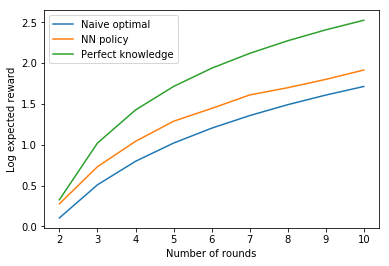

In [113]:
T_range = np.arange(2,11,1)
plt.plot(T_range, np.log(naive_opt_rewards), label="Naive optimal")
plt.plot(T_range, np.log(net_rewards), label="NN policy")
plt.plot(T_range, np.log(pk_rewards), label="Perfect knowledge")
plt.ylabel("Log expected reward")
plt.xlabel("Number of rounds")
plt.legend()
plt.show()

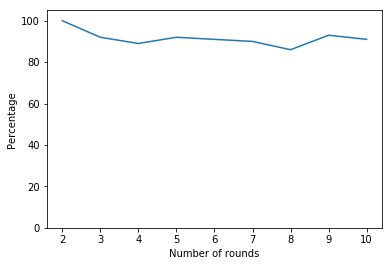

In [91]:
plt.plot(T_range, 100*np.array(win_loss_percs))
plt.ylabel("Percentage")
plt.xlabel("Number of rounds")
plt.ylim(0,105)
plt.show()

In [79]:
#plot of policy for T = 2
x_curr_i = 3
x_curr = g[x_curr_i]
g_const = g[(g <= g[x_curr_i] + ramp_const) & (g >= g[x_curr_i] - ramp_const)]
T = 4

policies = []

for t in [1,2,3]:
    net = nnet(net_params)
    net.load_state_dict(torch.load(base_path + "cdc_19/nets/T" + str(T) + ".torch"))
    net.eval()

    policy = []
    for s in s_vals:
        inputvec = torch.Tensor(np.array([x_curr, s, float(T-t)/float(T), 1.0])).unsqueeze(1).transpose(1,0)

        play_output = net(inputvec)
        play = float(play_output.data[0,0])

        #snap to nearest value in range
        if play > x_bar: play = x_bar
        if play < 0.0: play = 0.0

        #snap to nearest feasible value if constraints violated
        if np.abs(x_curr - play) > ramp_const:
            if play > x_curr: play = x_curr + ramp_const
            if play < x_curr: play = x_curr - ramp_const

        policy.append(play)
    policies.append(policy)
    
del(net)

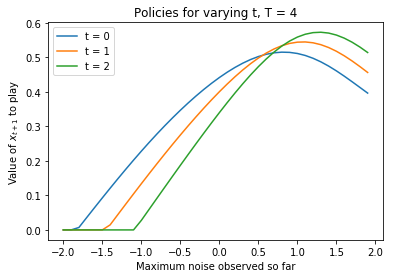

In [171]:
for t in range(3):
    plt.plot(s_vals, np.asarray(policies[t]), label="t = " + str(t))
plt.legend()
plt.ylabel("Value of $x_{t+1}$ to play")
plt.xlabel("Maximum noise observed so far")
plt.title("Policies for varying t, T = 4")
plt.show()

In [157]:
#bar plot of T = 2, 3, 4 difference between forward-simulated trained policy and grid optimal expected rewards
base_path = "/home/chase/projects/peakload/notebooks/"

nn_rewards = []
grid_rewards = []

for T in [2,3,4]:
    #load grid
    grid_opt = np.load(base_path + "t" + str(T) + "_grid_search.txt")
    
    #load nn
    net = nnet(net_params)
    net.load_state_dict(torch.load(base_path + "cdc_19/nets/T" + str(T) + ".torch"))
    net.eval()
    
    #realize sequences of noises
    s_i = [np.random.choice(np.arange(0,40,1), p=s_hist) for i in range(T)]
    s = [ s_vals[j] for j in s_i ]
    
    #grid_opt_path
    grid_plays = grid_search_optimal(3, s_i, grid_opt)
    
    noises = []
    plays = []
    x_curr = 0.4
    for j in range(T):
        t = j+1
        s_t = s[j]
        noises.append(s_t)
        
        s_m = np.max(noises)
        
        inputvec = torch.Tensor(np.array([x_curr, s_m, float(T-t)/float(T), 1.0])).unsqueeze(1).transpose(1,0)
            
        play_output = net(inputvec)
        play = float(play_output.data[0,0])

        #snap to nearest value in range
        if play > x_bar: play = x_bar
        if play < 0.0: play = 0.0

        #snap to nearest feasible value if constraints violated
        if np.abs(x_curr - play) > ramp_const:
            if play > x_curr: play = x_curr + ramp_const
            if play < x_curr: play = x_curr - ramp_const

        #attach previous play
        plays.append(x_curr)
        x_curr = play
        
    nn_reward = log_utility(np.array(plays)) - pi_cp*plays[np.argmax(s)]
    grid_reward = log_utility(np.array(grid_plays)) - pi_cp*grid_plays[np.argmax(s)]
    
    nn_rewards.append(nn_reward)
    grid_rewards.append(grid_reward)
    
    del(net)

/home/chase/applications/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/chase/applications/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
